# Epidemic Spreading

[Run notebook in Google Colab](https://colab.research.google.com/github/pathpy/pathpy/blob/master/doc/tutorial/epidemic_spreading.ipynb)  
[Download notebook](https://github.com/pathpy/pathpy/raw/master/doc/tutorial/epidemic_spreading.ipynb)

The class `BaseProcess` enables users to implement, simulate, and visualise custom-defined discrete-time dynamical processes. Some simple processes like the Susceptible-Infected-Recoverd (SIR) model for epidemic spreading are implemented in pathpy, mainly to illustrate how you can implement your own, more realistic model.

In this notebook, we demonstrate how we can simulate a simple spreading process in `pathpy`.

In [ ]:
pip install git+git://github.com/pathpy/pathpy.git

In [1]:
%matplotlib notebook
import pathpy as pp
import seaborn as sn
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

C:\Users\ingos\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We first need a network on which we will run the dynamical process. We will use the network of game of throne characters.

In [2]:
n = pp.io.graphtool.read_netzschleuder_network('game_thrones')
print(n)

Uid:			0x129f3888cc0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	107
Number of edges:	352

Network attributes
------------------
name:	game_thrones
description:	Network of coappearances of characters in the Game of Thrones series, by George R. R. Martin, and in particular coappearances in the book "A Storm of Swords." Nodes are unique characters, and edges are weighted by the number of times the two characters' names appeared within 15 words of each other in the text.[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.
citation:	[['A. Beveridge and J. Shan, "Network of Thrones." Math Horizons 23(4), 18-22 (2016)', 'https://doi.org/10.4169/mathhorizons.23.4.18']]
url:	http://www.macalester.edu/~abeverid/data/stormofswords.csv
tags:	['Social', 'Fictional', 'Weighted']
title:	Game of Thrones coappearances
bibtex:	['@article{Beveridge_2016,\n\tdoi = {10.4169/mathhorizons.23.4.18},\n\turl = {https://doi.org/10.4169%2Fmathhorizon

Inspecting the node attributes above, we find that we can use the node-level attribute `name` to plot the network:

In [3]:
n.plot(node_label={v.uid: v['name'] for v in n.nodes}, label_color='black')

To simulate the SIR epidemic spreading process, we must first initialize the process. We can do this by creating a new instance of the class `pp.processes.EpidemicSIR`. The constructor takes three parameters. The first parameter is the network on which we want to simulate the process. The second parameter is the recovery time, i.e. the number of time steps for which an infected node is infected before it recovers (and becomes immune). The third parameter is the per-time step probability by which a susceptible node that is connected to an infected node becomes infected.

In [4]:
sir = pp.processes.EpidemicSIR(n, recovery_time=20, infection_prob=0.05)

Now that our experiment is setup, we can run it. This can be done in two ways: 

The first method is to use the `simulation_run` iterator, which allows us to iterate through the steps of the process. After each discrete time step of the simulation, this iterator will yield a tuple consisting of the current time and a set of nodes whose state has been changed in the current step. In the SIR model, this state change can either be due to a susceptible node becoming infected, or an infected node changing to recovered. We can use the method `sir.node_state` to check the current state of each node in the network. 

In the SIR model, the three states corresponding to the three compartments `susceptible`, `infected`, `recovered` are encoded by the integer values `0`, `1`, and `2` respectively. Hence, to print a list of newly infected nodes in each step, we can write:

In [5]:
for time, changed_nodes in sir.simulation_run(steps=20):
    print('time = {0}: {1}'.format(time, [v for v in changed_nodes if sir.node_state(v)==1]))

time = 1: []
time = 2: []
time = 3: []
time = 4: []
time = 5: []
time = 6: ['16', '48']
time = 7: []
time = 8: ['4']
time = 9: ['3']
time = 10: ['23', '43', '79']
time = 11: ['40', '45', '37']
time = 12: ['6', '27']
time = 13: ['19', '42', '96', '54', '100', '26', '85']
time = 14: ['20']
time = 15: ['53', '46', '5', '52', '80']
time = 16: ['50', '49', '38', '84', '47']
time = 17: ['75', '57', '7', '94', '24', '12', '56', '51', '22']
time = 18: ['17', '98', '21', '14', '29', '83']
time = 19: ['2', '41', '103', '44']
time = 20: ['55', '9', '11', '69', '87', '18']


In the example above, the seed node that is initially infected (at time 0) is chosen uniformly at random. If we want to start the simulation with a specific seed node, we can pass the uid of the initially infected node via the `seed` parameter:

In [6]:
for time, changed_nodes in sir.simulation_run(steps=20, seed='0'):
    print('time = {0}: {1}'.format(time, [v for v in changed_nodes if sir.node_state(v)==1]))

time = 1: []
time = 2: []
time = 3: []
time = 4: ['5']
time = 5: []
time = 6: ['21']
time = 7: ['3', '87', '29', '1']
time = 8: ['48']
time = 9: ['22', '15']
time = 10: ['75', '35']
time = 11: ['76', '4', '42']
time = 12: ['12', '88', '51']
time = 13: ['17', '46', '79', '2', '6']
time = 14: ['50', '16', '98', '36', '7']
time = 15: ['101', '55', '58', '41', '103', '57']
time = 16: ['53', '8', '23', '100', '83', '24', '97', '25', '20', '102']
time = 17: ['81', '89', '45', '13']
time = 18: ['56', '91', '27', '11', '14', '80']
time = 19: ['63', '37', '93', '44', '78', '94']
time = 20: ['54', '26', '69']


A common task in the simulation of stochastic processes is the executing of multiple runs with random initializations. Rather than requiring the user to collect the result of the individual simulation runs ourselves via the `simulation_run` iterator, `pathpy` provides a `run_experiment` function that makes this task simple. We can simply specify the numer of steps for which we wish to simulate process, as well as the number of times the experiment shall be executed (runs). 

For each run a new random seed node will be chosen automatically.

In [7]:
data = sir.run_experiment(steps=20, runs=10)

This method returns a `pandas.DataFrame` which collects the full evolution of the process. Each row in the data frame stores a single state change of a node in a given run and time step along with the updated state. This data frame allows us to reconstruct the full dynamics, and execute downstream analyses and visualisations. Only updates to states are stored, i.e. unchanged states of nodes are omitted.

In [8]:
data.head()

,run_id,seed,time,node,state
0,0,1,0,53,0
1,0,1,0,27,0
2,0,1,0,30,0
3,0,1,0,83,0
4,0,1,0,35,0


As an example, let us plot the evolution of the average total number of infections over time, as well as the average number of new infections in each time step, across the 10 runs of the process. To plot this, we can write:

<IPython.core.display.Javascript object>


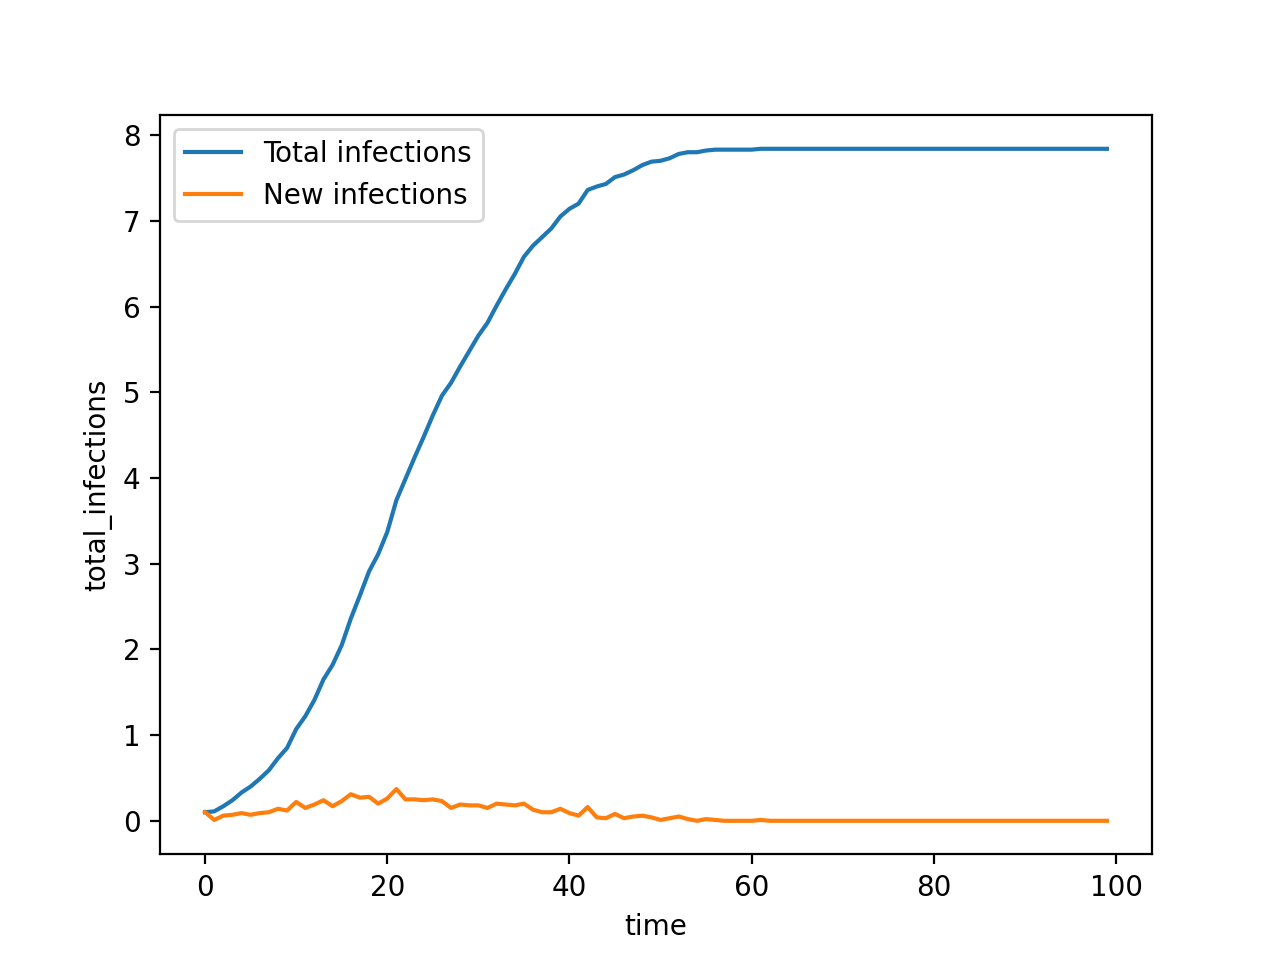

In [9]:
dynamics = [] 
total_infections = 0
for t in range(100):
    new_infections = len(data.loc[(data['time']==t) & (data['state']==1)])/100
    total_infections += new_infections
    dynamics.append({ 
        'time': t,
        'new_infections': new_infections, 
        'total_infections': total_infections}
    )

dynamics = pd.DataFrame.from_dict(dynamics)
sn.lineplot(data=dynamics, x='time', y='total_infections', label='Total infections')
sn.lineplot(data=dynamics, x='time', y='new_infections', label='New infections')
plt.legend()

Finally, there is a simple method to generate an interactive visualisation of the dynamical process in the network. We can simply call the `plot` function of the process instance, passing the data frame that we collected in our experiment. Since this data frame can contain data on more than one simulation run, we can specify the id of the run that we wish to visualize. If we omit this parameter, the first run will be shown.

In [10]:
sir.plot(data, run_id=0)

In [11]:
sir.plot(data, run_id=1)

To simplify matters, the following line executes and visualizes a single run of the process with a random seed node.

In [12]:
sir.plot(sir.run_experiment(steps=100))

Finally, we can use the sequence of state changes recorded in the evolution of a process run to extract a directed acyclic grap of possible causal influences between nodes. In this directed acyclic graph, each change of a state of node w at time t is represented by a time-unfolded node 'w-t'., i.e. the directed acyclic graph can be thought of as a time-unfolded static representation of the process evolution. In addition, an edge (v-t', w-t) indicates that prior to node w changing its state, a node v connected to w changed its state at time t'<t. We can limit the directed acyclic graph construction to specific state changes. In the following example, we use a directed acyclic graph to capture possible transmission routes of the epidemic process in a small example network.

In [5]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('a', 'c')
n.add_edge('c', 'd')
n.add_edge('c', 'e')
n.add_edge('d', 'e')
n.add_edge('c', 'b')
n.plot()

In [6]:
sir = pp.processes.EpidemicSIR(n, recovery_time=10, infection_prob=0.5)
data = sir.run_experiment(steps = 50, runs=['a'])
print(data)

    run_id seed  time node  state
0        0    a     0    b      0
1        0    a     0    d      0
2        0    a     0    e      0
3        0    a     0    a      1
4        0    a     0    c      0
5        0    a     1    b      1
6        0    a     1    c      1
7        0    a     2    e      1
8        0    a     5    d      1
9        0    a    12    b      2
10       0    a    12    c      2
11       0    a    12    a      2
12       0    a    13    e      2
13       0    a    16    d      2


In [7]:
dag = sir.to_directed_acylic_graph(data, states=[1])
print(dag)
dag.plot()

Uid:			0
Type:			DirectedAcyclicGraph
Acyclic:		None
Multi-Edges:		False
Number of nodes:	5
Number of edges:	4
Number of roots:	1
Number of leafs:	2
